# CNN Dog Breed Classication

The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. This dataset is being imported from Kaggle

The contents of the dataset are:

 - **Number of categories**: 120
 - **Number of images**: 20,580
Since there are only about 170 images per category. It would be beneficial to use transfer learning.

I will be using the pre-trained model Inception V3 which has been trained on 'imagenet'. The weights will be freezed.

## Libraries

In [29]:
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_hub as hub

import matplotlib.pyplot as plt

import math
import numpy as np
import os


In [26]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [27]:
IMAGE_SIZE = 256
BATCH_SIZE = 128
CHANNELS = 3

In [30]:
inception = tf.keras.applications.InceptionV3(input_shape = (200,200,3),include_top=False, weights='imagenet')
inception.trainable = False #The layers are frozen

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory="Dataset/Images/",
    shuffle=True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE,
)

Found 20580 files belonging to 120 classes.


2024-05-14 11:06:23.597076: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-14 11:06:23.597445: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-14 11:06:23.597741: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-14 11:06:23.770311: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-14 11:06:23.770753: I external/local_xla/xla/stream_executor

In [ ]:
class_names = dataset.class_names

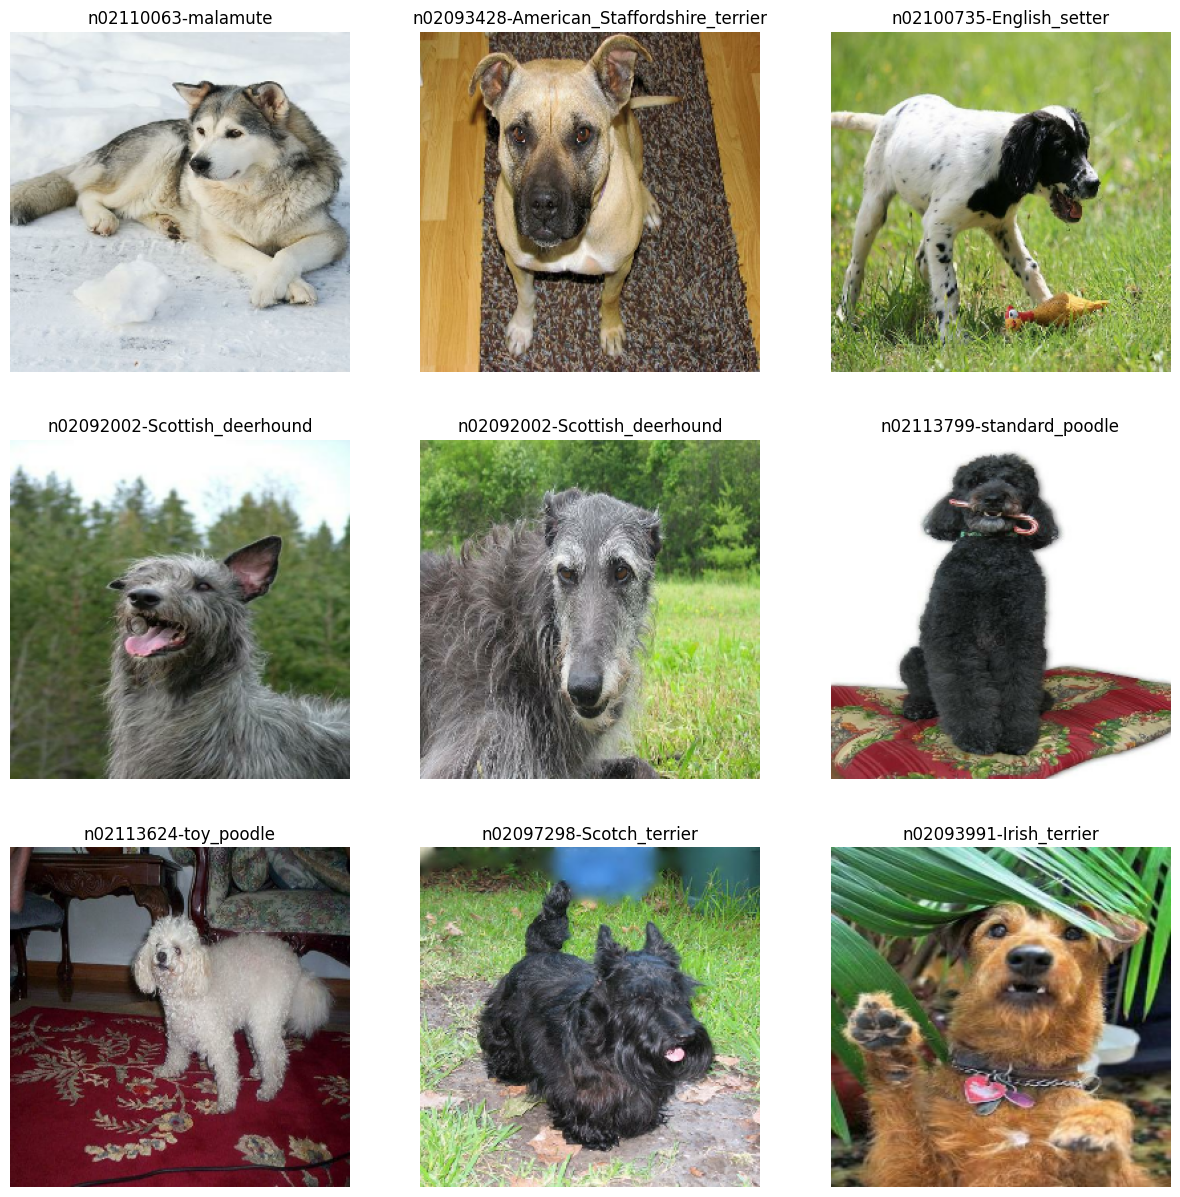

In [ ]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(len(ds) * train_split)
    val_size = int(len(ds) * val_split)
    test_size = int(len(ds) * test_split)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size).take(test_size)
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(128, (3,3), padding='same', activation='relu', input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape)

In [ ]:

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (128, 256, 256, 3)        0         
                                                                 
 sequential_1 (Sequential)   (128, 256, 256, 3)        0         
                                                                 
 conv2d (Conv2D)             (128, 256, 256, 128)      3584      
                                                                 
 max_pooling2d (MaxPooling2  (128, 128, 128, 128)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (128, 128, 128, 256)      295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (128, 64, 64, 256)        0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
EPOCHS = 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1
    
)

Epoch 1/50


/home/tavera/projects/dog_breed_cnn/venv/lib/python3.9/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


: 